In [7]:
%matplotlib inline

from collections import Counter, defaultdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats.stats import pearsonr
import cPickle as pkl
from datetime import datetime

import seaborn as sns

In [8]:
all_files = [fname for fname in os.listdir('data') if fname[-4:] == "json" and '2015-01' in fname]


In [14]:
 
def extract_features(n_files):# load all events
    rdata = defaultdict(dict) # number of times each user interacted, number of each event
    udata = defaultdict(dict) # number of each event
    data = defaultdict(dict)
    users = set()
    repos = set()
    for i, fname in enumerate(all_files[:n_files]):
        if i % 5 == 0:
            print (i + 1), "out of", len(all_files), "files loaded"
        for line in open(os.path.join("data", fname), 'r'):
            e = json.loads(line)
            user = e['actor']['login']
            repo = e['repo']['name']
            users.add(user)
            repos.add(repo)
            if (user,repo) in data:
                data[(user,repo)]['actions'].append(e['type'])
                data[(user,repo)]['times'].append(datetime.strptime(e['created_at'], "%Y-%m-%dT%H:%M:%SZ"))
                if e['type'] == 'PushEvent':
                    data[(user,repo)]['commits'] += e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    data[(user,repo)]['starred'] = True
                if e['type'] == 'ForkEvent':
                    data[(user,repo)]['forked'] = True
            else:
                data[(user,repo)]['user_is_owner'] = (user + '/') in repo
                data[(user,repo)]['actions'] = [e['type']]
                data[(user,repo)]['times'] = [datetime.strptime(e['created_at'], "%Y-%m-%dT%H:%M:%SZ")]
                data[(user,repo)]['commits'] = 0
                if e['type'] == 'PushEvent':
                    data[(user,repo)]['commits'] = e['payload']['distinct_size']



            if repo in rdata:
                rdata[repo]['actions'].append(e['type'])
                if e['type'] == 'PushEvent':
                    rdata[repo]['commits'] += e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    rdata[repo]['stars'] += 1
                if e['type'] == 'ForkEvent':
                    rdata[repo]['forks'] += 1
            else:
                rdata[repo]['commits'] = 0
                rdata[repo]['stars'] = 0
                rdata[repo]['forks'] = 0
                rdata[repo]['actions'] = [e['type']]
                if e['type'] == 'PushEvent':
                    rdata[repo]['commits'] = e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    rdata[repo]['stars'] = 1
                if e['type'] == 'ForkEvent':
                    rdata[repo]['forks'] = 1
            if user in udata:
                udata[user]['actions'].append(e['type'])
                udata[user]['times'].append(datetime.strptime(e['created_at'], "%Y-%m-%dT%H:%M:%SZ"))
            else:
                udata[user]['actions'] = [e['type']]
                udata[user]['times']= [datetime.strptime(e['created_at'], "%Y-%m-%dT%H:%M:%SZ")]

    ucommits = defaultdict(int)
    urepos = defaultdict(set)
    rcommits = defaultdict(int)
    rusers = defaultdict(set)
    for (u,r) in data.keys():
        d = data[(u,r)]
        ucommits[u] += d['commits']
        urepos[u].add(r)
        rcommits[r] += d['commits']
        rusers[r].add(u)

    users = set([u for u,_ in data.keys()])
    repos = set([r for _,r in data.keys()])
    for u in users:
        uaction_counter = Counter(udata[u]['actions'])
        udata[u]['num_forks'] = uaction_counter['ForkEvent']
        udata[u]['num_pushes'] = uaction_counter['PushEvent']
        udata[u]['num_stars'] = uaction_counter['WatchEvent']
        udata[u]['num_commits'] = ucommits[u]
        udata[u]['repos'] = urepos[u]
    for r in repos:
        rdata[r]['users'] = rusers[r]
    return rdata, udata, data, users, repos

In [15]:
rdata, udata, data, users, repos = extract_features(60)



1 out of 720 files loaded
6 out of 720 files loaded
11 out of 720 files loaded
16 out of 720 files loaded
21 out of 720 files loaded
26 out of 720 files loaded
31 out of 720 files loaded
36 out of 720 files loaded
41 out of 720 files loaded
46 out of 720 files loaded
51 out of 720 files loaded
56 out of 720 files loaded


In [16]:
# prune data: rdata, udata, data, users, repos
print rdata.items()[0][1].keys()
print udata.items()[0][1].keys()
print data.items()[0][1].keys()
users = set(users)
users_list = list(users)
repos = set(repos)
repos_list = list(repos)
print 'ulen', len(users)
print 'rlen', len(repos)
print 'dlen', len(data)
for u in users_list:
    if len(udata[u]['repos']) < 4 or len(udata[u]['actions']) < 20:
        users.remove(u)
        udata.pop(u, None)
for r in repos_list:
    if len(rdata[r]['users']) < 4 or len(rdata[r]['actions']) < 20:
        repos.remove(r)
        rdata.pop(r, None)
for (u,r) in data.keys():
    if u not in users or r not in repos:
        data.pop((u,r), None)
print 'ulen_after', len(users)
print 'rlen_after', len(repos)
print 'dlen_after', len(data)

['commits', 'forks', 'actions', 'stars', 'users']
['num_stars', 'repos', 'actions', 'times', 'num_forks', 'num_pushes', 'num_commits']
['commits', 'user_is_owner', 'actions', 'times']
ulen 285592
rlen 334163
dlen 499321
ulen_after 4459
rlen_after 3767
dlen_after 7747


In [17]:
# pkl.dump((rdata, udata, data, users, repos), open('data_structuring.pkl', 'wb')) # DUMP
rdata, udata, data, users, repos = pkl.load(open('data_structuring.pkl', 'rb')) # LOAD

In [18]:
numforks = [b['forks'] for _,b in rdata.items()]
numstars = [b['stars'] for _,b in rdata.items()]
print pearsonr(numforks, numstars)

(0.1204356292065373, 1.2034725849561794e-13)


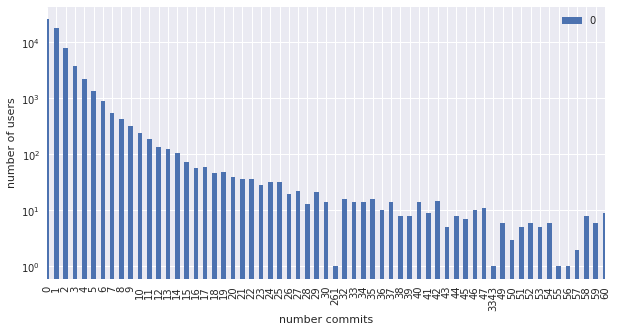

In [22]:
c = Counter(ucommits.values())
df = pd.DataFrame.from_dict(c, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number commits")
plt.ylabel("number of users")
plt.xlim([0,60])
plt.show()

In [28]:
for i, fname in enumerate(all_files[:1]):
    if i+1 %1 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        from pprint import pprint
        pprint(e)
        break
    break

0 out of 720 files loaded
{u'actor': {u'avatar_url': u'https://avatars.githubusercontent.com/u/1484298?',
            u'gravatar_id': u'',
            u'id': 1484298,
            u'login': u'minhhai3b',
            u'url': u'https://api.github.com/users/minhhai3b'},
 u'created_at': u'2015-01-13T02:00:00Z',
 u'id': u'2508406478',
 u'payload': {u'forkee': {u'archive_url': u'https://api.github.com/repos/minhhai3b/CakePHP-Backbone-Todos/{archive_format}{/ref}',
                          u'assignees_url': u'https://api.github.com/repos/minhhai3b/CakePHP-Backbone-Todos/assignees{/user}',
                          u'blobs_url': u'https://api.github.com/repos/minhhai3b/CakePHP-Backbone-Todos/git/blobs{/sha}',
                          u'branches_url': u'https://api.github.com/repos/minhhai3b/CakePHP-Backbone-Todos/branches{/branch}',
                          u'clone_url': u'https://github.com/minhhai3b/CakePHP-Backbone-Todos.git',
                          u'collaborators_url': u'https://api.